# Computer Vision project - Plant Disease Detection
## Leaf Rot Recognition

#### Group: Biddiscombe, Gritti, Sedra

In [1]:
# General imports
import numpy as np 
import matplotlib.pyplot as plt

# Image visualisation and manipulation
from PIL import Image
# import av
# import skimage
import numpy as np
import random
import tensorflow as tf

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

2025-12-07 16:41:22.791137: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load the data
For leaf disease segmentation we have downloaded 2 datasets, one which contains a diverse range of images taken from the internet, of different sizes and different contents, and another larger one with regularly sized images that contain certain deiseases only. 
This second dataset is cleaner and more informative, with clearer masks and better labels, but is very heavy as the images are large (1200 by 2000 pixels).

To use the data more easily, we need a way to downsample the data. 
We created two functions to do this, which should allow for better model creationg and training later in the project.

### Dataset 1 - 588 diverse images
This dataset contains images of various plants, with some unspecified kinds of leaf diseases. 
The masks are mostly informative, but the data is too small due to the diversity of the images contained, so it is not ideal for training a model for classification. 
We intend to use this dataset as an external, additional testing set, if everything else goes well.

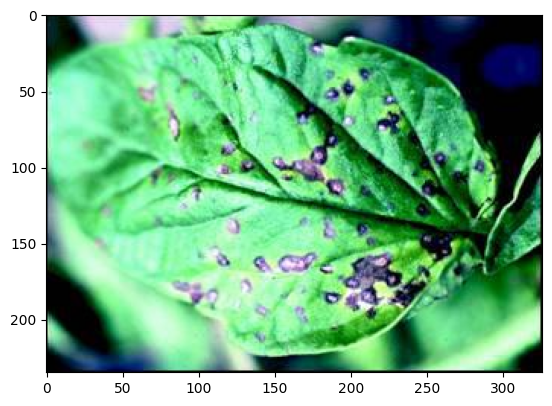

In [2]:
# Display an image to test correctness
path_to_588_images = "data_588_leafs/images/"
path_to_588_masks = "data_588_leafs/masks/"
image_0_path = path_to_588_images + "00000.jpg"
image_0 = Image.open(image_0_path)

plt.imshow(image_0)
plt.show()

## Loading the data efficiently
To load the data efficiently, we created two functions: one to downsample images and masks to a specified size, and another to load the dataset from a given directory structure.
Previously, we had issues with memory usage when trying to load the full-resolution images and converting them to np.arrays directly. These functions help mitigate that by resizing the images and masks during the loading process.

In [3]:

# return array representing an image, downsampled by a rate
def downsample(im_path, ds_rate = 10):
    img = np.array(Image.open(im_path))
    if len(img.shape) == 3:
        return img[::ds_rate, ::ds_rate, :]
    return img[::ds_rate, ::ds_rate]

# return image downsampled enough to closely fit the wished for size
def open_and_scale(im_path, reference_size=250):
    img = np.array(Image.open(im_path))
    if reference_size  == 0:
        return img
    im_shape = img.shape
    ds_rate = im_shape[0] // reference_size
    return downsample(im_path, ds_rate= max(1, ds_rate)) #capping the ds_rate to be at least 1


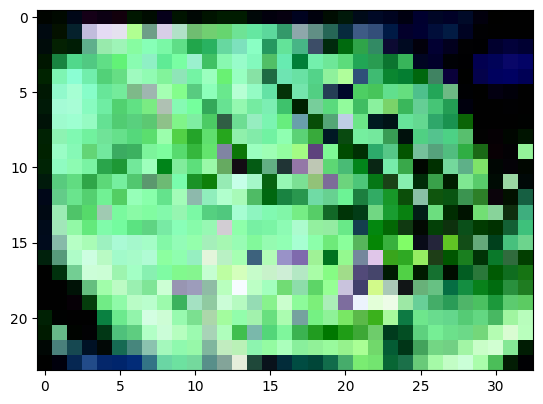

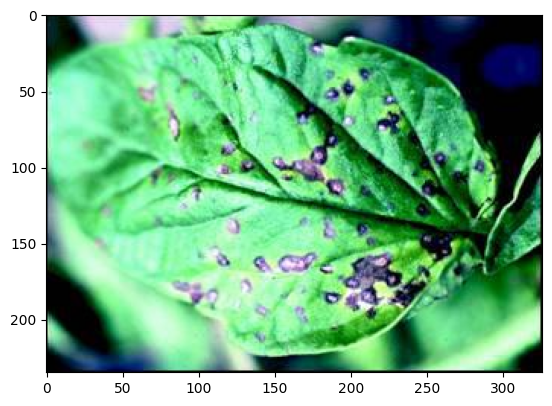

In [4]:
plt.imshow(downsample(image_0_path))
plt.show()

# note: do not use first function for dataset 1 images because they are too small already

plt.imshow(open_and_scale(image_0_path))
plt.show()

Above is shown an example of too high downsampling rate causing loss of information.

## Visualizing the leafs and their masks

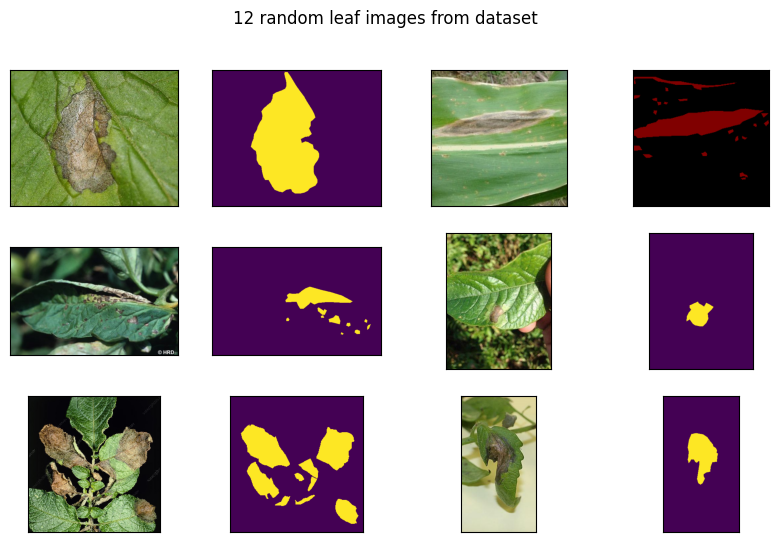

In [5]:
nr_imgs = 588

random_selection = []

plt.figure(figsize=(10,6))

i = 0

while len(random_selection) < 6:
    rand_nr = np.random.randint(nr_imgs)
    if rand_nr in random_selection:
        continue
    
    i += 1
    random_selection.append(rand_nr)
    plt.subplot(3,4,i)
    img = open_and_scale(path_to_588_images + f"{rand_nr:05d}.jpg")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    i += 1
    plt.subplot(3,4,i)
    img = open_and_scale(path_to_588_masks + f"{rand_nr:05d}.png")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

plt.suptitle("12 random leaf images from dataset")
plt.show()

In [6]:
def plot_random_selection(im_number=588, nr_to_plot=6, 
                          ims_path="data/data/images/", 
                          masks_path="data/data/masks/", 
                          img_name="",
                          mask_name=""):
    
    x_plots = int(round(np.sqrt(nr_to_plot) + 0.4))
    y_plots = int(round(nr_to_plot / x_plots + 0.4))

    plt.figure(figsize=(10,4))
    random_selection = []
    i = 0

    while len(random_selection) < nr_to_plot:
        rand_nr = np.random.randint(im_number)
        if rand_nr in random_selection:
            continue
        
        random_selection.append(rand_nr)
        
        i += 1
        plt.subplot(y_plots, x_plots * 2, i)
        img = open_and_scale(ims_path + f"{img_name}{rand_nr:05d}.jpg")
        plt.imshow(img)
        # plt.title(f"leaf {int(round(i/2))}")
        plt.xticks([])
        plt.yticks([])

        i += 1
        plt.subplot(y_plots, x_plots * 2, i)
        img = open_and_scale(masks_path + f"{mask_name}{rand_nr:05d}.png")
        plt.imshow(img)        
        # plt.title(f"mask {int(round(i/2))}")
        plt.xticks([])
        plt.yticks([])
    
    plt.suptitle(f"{nr_to_plot} random images from dataset, with masks")
    # plt.tight_layout()
    plt.show()


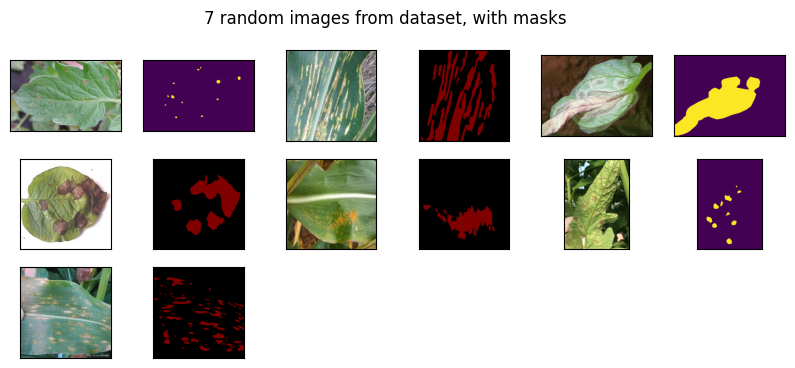

In [7]:
plot_random_selection(ims_path = path_to_588_images, masks_path=path_to_588_masks, im_number=588, nr_to_plot=7)

### Dataset 2 - Apple dataset
The second dataset contains more samples, which are not only regular in size (1200 x 2000 px), but are also clearly labelled and separated by disease type.
All leaves represent apple leaves, but are separated into categories: 
- "health" for healthy leaves with no associated masks; 
- "scab" for apple leaves affected by the scabs disease, a fungal infection that leaves brown sometimes oval shaped spots covering the leaves; 
- "rust" for leaves affected by the rust plant disease, another fungal infection that leaves yellowins spots on the affected area.

Images from this dataset are far too large and need to be downscaled for use (when training the data without downscaling we could only use 100 images at a time, due to the high memory cost, 4GB of cache just for the image list).

### Declaring paths

In [8]:
# trying to use it on new data
path_to_apple_imgs_scab = "data_1291_leafs/img_scab/"
path_to_apple_masks_scab = "data_1291_leafs/masks_machine_scab/"

path_to_apple_imgs_rust = "data_1291_leafs/img_rust/"
path_to_apple_masks_rust = "data_1291_leafs/masks_machine_rust/"

path_to_apple_imgs_both = "data_1291_leafs/img_both/"
path_to_apple_masks_both = "data_1291_leafs/masks_machine_both/"

path_to_apple_imgs_health = "data_1291_leafs/img_health/"
# there are no masks for health, would be a np.zeros_like(im_health_array)

img_name_system = "Train_" # Train_0.jpg, Train_1820.jpg
mask_name_system = "Train_" # Train_0.png, Train_1820.png
# Note: NOT ALL INDEXES HAVE ASSOCIATED IMAGES


In [9]:
# create a plotting function to visualise random leaves
def plot_random_scab(im_number=1820, nr_to_plot=6, 
                     ims_path=path_to_apple_imgs_scab, 
                     masks_path=path_to_apple_masks_scab, 
                     img_name="",
                     mask_name=""):
    
    x_plots = int(round(np.sqrt(nr_to_plot) + 0.4))
    y_plots = int(round(nr_to_plot / x_plots + 0.4))

    plt.figure(figsize=(10,4))
    random_selection = []
    i = 0

    while len(random_selection) < nr_to_plot:
        rand_nr = np.random.randint(im_number)
        if rand_nr in random_selection:
            continue
        
        try:
            img = open_and_scale(ims_path + f"{img_name}{rand_nr}.jpg")
        except: 
            continue

        random_selection.append(rand_nr)
        i += 1
        plt.subplot(y_plots, x_plots * 2, i)
        plt.imshow(img)
        # plt.title(f"leaf {int(round(i/2))}")
        plt.xticks([])
        plt.yticks([])

        i += 1
        plt.subplot(y_plots, x_plots * 2, i)
        img = open_and_scale(masks_path + f"{mask_name}{rand_nr}.png")
        plt.imshow(img)        
        # plt.title(f"mask {int(round(i/2))}")
        plt.xticks([])
        plt.yticks([])
    
    plt.suptitle(f"{nr_to_plot} random images from dataset, with masks")
    # plt.tight_layout()
    plt.show()


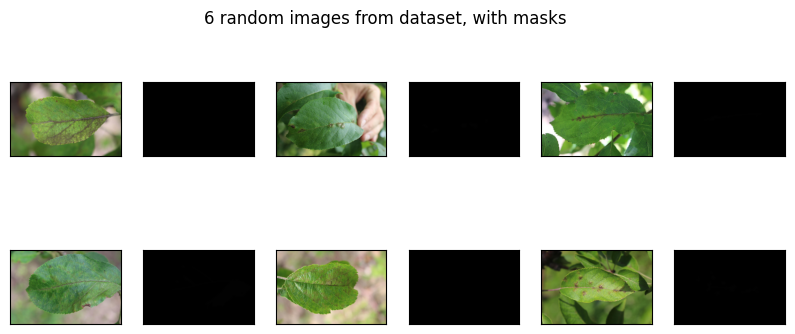

In [10]:
plot_random_scab(img_name=img_name_system, mask_name=mask_name_system)

### Mask visibility
The masks looks like totally black images, but the images that represent the masks do contain some information about the masks, it is simply stored in the wrong way.
The masks are stored as images, with 3 colour channels and expected values of integers between 0 and 255, but the actual information is invisible as the largest number in the mask colour channel data is "2".

We create a function to transform the masks and make them visible.

(273, 410, 3)
(273, 410)
368


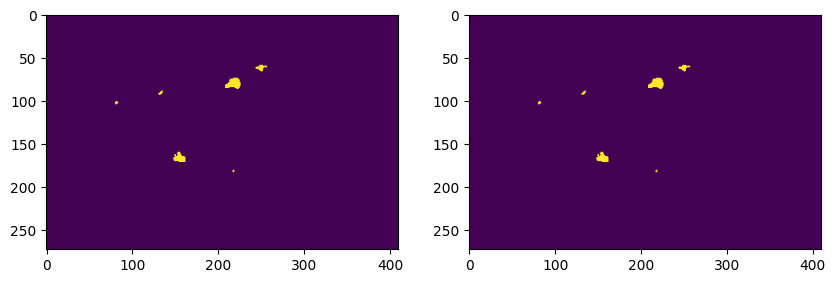

In [11]:
# trying different dataset
img = open_and_scale(path_to_apple_masks_scab + mask_name_system + "0.png")
# plt.imshow(img)

print(img.shape)

gray_img = np.mean(img, axis=2) # converting to grayscale by averaging the 3 channels
print(gray_img.shape)

mask = gray_img > 0
print(len(img[mask]))

# plotting the average mask value (over the 3 colour inputs) against the absolute truth value
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(gray_img)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

# There is not much difference between the average and the truth value

## Creating function to transform masks

In [12]:
# Create functions to more easily view the masks.
def transform_mask(mask):
    mask = np.array(mask)
    mask[:,:,1:3] = 0 # make it red
    mask = mask > 0
    return mask * 255 # outputs red mask, only colour input 0 (first one, volour red) has any values

# plt.imshow(transform_mask(path_to_masks + mask_name_system + "0.png"))

def transform_binary_mask(mask):
    mask = np.array(mask)
    if mask.ndim == 3:
        mask = np.sum(mask, axis=2)
    mask = mask > 0
    return mask # outputs binary values of mask

In [13]:
def plot_random_leaf_mask(type="scab", 
                          nr_to_plot=6, im_number=1820, 
                          img_name=img_name_system,
                          mask_name=mask_name_system):
    if type == "scab":
        ims_path = path_to_apple_imgs_scab
        masks_path = path_to_apple_masks_scab
    elif type == "rust":
        ims_path = path_to_apple_imgs_rust
        masks_path = path_to_apple_masks_rust
    elif type == "both":
        ims_path = path_to_apple_imgs_both
        masks_path = path_to_apple_masks_both
    else:
        print("This type does not work.")
        return

    x_plots = int(round(np.sqrt(nr_to_plot) + 0.4))
    y_plots = int(round(nr_to_plot / x_plots + 0.4))

    plt.figure(figsize=(10,4))
    random_selection = []
    i = 0

    while len(random_selection) < nr_to_plot:
        rand_nr = np.random.randint(im_number)
        if rand_nr in random_selection:
            continue
        
        try:
            img = open_and_scale(ims_path + f"{img_name}{rand_nr}.jpg")
        except: 
            continue

        random_selection.append(rand_nr)
        i += 1
        plt.subplot(y_plots, x_plots * 2, i)
        plt.imshow(img)
        # plt.title(f"leaf {int(round(i/2))}")
        plt.xticks([])
        plt.yticks([])

        i += 1
        plt.subplot(y_plots, x_plots * 2, i)
        mask = open_and_scale(masks_path + f"{mask_name}{rand_nr}.png")
        mask = transform_mask(mask)
        plt.imshow(mask, cmap="gray")        
        # plt.title(f"mask {int(round(i/2))}")
        plt.xticks([])
        plt.yticks([])
    
    plt.suptitle(f"{nr_to_plot} random {type if type != "both" else "diseased"} images, with masks")
    # plt.tight_layout()
    plt.show()


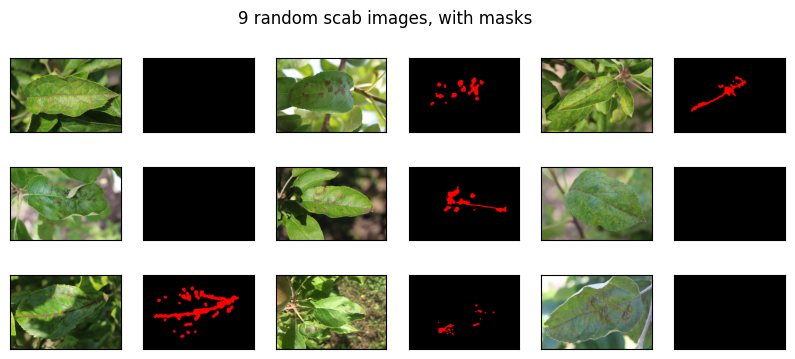

In [14]:
plot_random_leaf_mask(nr_to_plot=9, type="scab")

In [15]:
def plot_leaf_and_mask_in_axs(img_name, path_to_leaf, path_to_mask, axs):
    try:
        img = open_and_scale(path_to_leaf)
    except:
        print(f"Error loading leaf image {img_name}")
        return
    leaf = open_and_scale(path_to_leaf)
    mask = open_and_scale(path_to_mask)
    red_mask = transform_mask(mask)
    leaf_array = np.array(leaf)
    red_mask_array = np.array(red_mask)
    overlay = np.clip(leaf_array + red_mask_array, 0, 255)

    # Plot the images (leaf, mask, leaf with mask)
    axs[0].imshow(leaf)
    axs[1].imshow(red_mask)
    axs[2].imshow(overlay)
    # Add the titles
    axs[0].set_title(f"Leaf {img_name}")
    axs[1].set_title("Disease mask")
    axs[2].set_title(f"Disease on leaf {img_name}")
    
    for ax in axs:
        ax.axis("off")


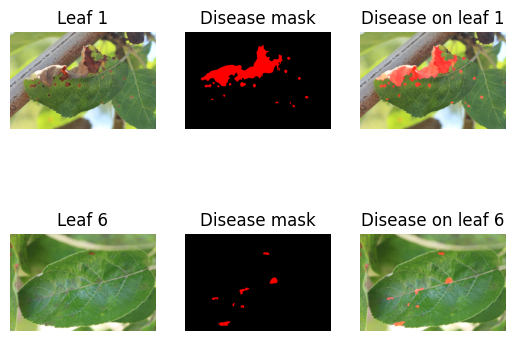

In [16]:
f, (axs1, axs2) = plt.subplots(nrows=2,ncols=3)

# test
plot_leaf_and_mask_in_axs("1", path_to_apple_imgs_both + img_name_system + "1.jpg", path_to_apple_masks_both + mask_name_system + "1.png", axs1)
plot_leaf_and_mask_in_axs("6", path_to_apple_imgs_both + img_name_system + "6.jpg", path_to_apple_masks_both + mask_name_system + "6.png", axs2)


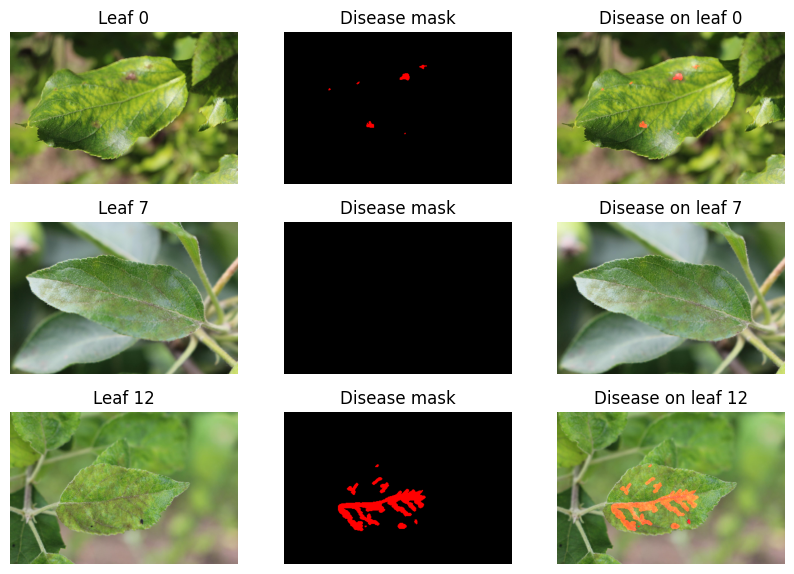

In [17]:
f, (axs1, axs2, axs3) = plt.subplots(nrows=3, ncols=3)
f.set_figwidth(10)
f.set_figheight(7)


# test
plot_leaf_and_mask_in_axs("0", path_to_apple_imgs_scab + img_name_system + "0.jpg", path_to_apple_masks_scab + mask_name_system + "0.png", axs1)
plot_leaf_and_mask_in_axs("7", path_to_apple_imgs_scab + img_name_system + "7.jpg", path_to_apple_masks_scab + mask_name_system + "7.png", axs2)
plot_leaf_and_mask_in_axs("12", path_to_apple_imgs_scab + img_name_system + "12.jpg", path_to_apple_masks_scab + mask_name_system + "12.png", axs3)


### Dataset quality note
We notice that some images, even if they have an associated mask file, may not have any information relating to the disease.
Because of this it is necessary to only take into account the images with informative masks for the later model training, and therefore we need to clean up the set of data that will be used in the rest of teh notebook.
We create functions to check the contents of the masks and store them if they contain information.

We will store the apple leaf dataset and the 588 random leaves separately.

In [18]:
# def check_image_of_1291_dataset(path_to_images, img_name_system):
#     existing_images = []
#     for i in range(3000):
#         try:  
#             img = Image.open(path_to_images + img_name_system + f"{i}.jpg")
#             img = open_and_scale_array(np.array(img))
#             existing_images.append(img)
#         except:
#             continue

#     print(f"Found {len(existing_images)}")
#     return existing_images

# def check_masks_of_1291_dataset(path_to_masks, mask_name_system):
#     existing_masks = []
#     for i in range(3000):
#         try:
#             img = Image.open(path_to_masks + mask_name_system + f"{i}.png")
#             img = open_and_scale_array(np.array(img))
#             # img = transform_binary_mask(img)
#             existing_masks.append(img) # make the masks binary
#         except:
#             continue

#     print(f"Found {len(existing_masks)}")
#     return existing_masks

# def check_image_of_588_dataset(path_to_images):
#     existing_images = []
#     for i in range(588):
#         try:
#             img = Image.open(path_to_images + img_name_system + f"{i:05d}.jpg")
#             img = open_and_scale_array(np.array(img))
#             existing_images.append(img)
#         except:
#             continue

#     print(f"Found {len(existing_images)}")
#     return existing_images

# def check_masks_of_588_dataset(path_to_masks):
#     existing_masks = []
#     for i in range(588):
#         try:
#             img = Image.open(path_to_masks + mask_name_system + f"{i:05d}.png")
#             img = open_and_scale_array(np.array(img))
#             # img = transform_binary_mask(img) # make the masks binary
#             existing_masks.append(img)
#         except:
#             continue

#     print(f"Found {len(existing_masks)}")
#     return existing_masks


The functions above are commented out because they were not necessary anymore, in fact loading all the images and masks into memory at once was not feasible due to memory constraints.Instead we're going to store the available indexes of images with informative masks, and then load them later on demand during model training.

In [19]:
def get_existing_image_indexes(path_to_images, img_name_system):
    existing_indexes = []
    for i in range(3000):
        try:  
            Image.open(path_to_images + img_name_system + f"{i}.jpg")
            existing_indexes.append(i)
        except:
            continue

    print(f"Found {len(existing_indexes)}")
    return existing_indexes

def get_existing_mask_indexes(path_to_masks, mask_name_system):
    existing_indexes = []
    for i in range(3000):
        try:
            Image.open(path_to_masks + mask_name_system + f"{i}.png")
            existing_indexes.append(i) # make the masks binary
        except:
            continue

    print(f"Found {len(existing_indexes)}")
    return existing_indexes


In [20]:
path_to_images_general_disease = "data_588_leafs/images/"
path_to_masks_general_disease = "data_588_leafs/masks/"


print("Images with scab from apple dataset:")
imgs_scab_idxs = get_existing_image_indexes(path_to_apple_imgs_scab, img_name_system)
print("Masks with scab from apple dataset:")
masks_scab_idxs = get_existing_mask_indexes(path_to_apple_masks_scab, mask_name_system)
print()
print("Images with rust from apple dataset:")
imgs_rust_idxs = get_existing_image_indexes(path_to_apple_imgs_rust, img_name_system)
print("Masks with rust from apple dataset:")
masks_rust_idxs = get_existing_mask_indexes(path_to_apple_masks_rust, mask_name_system)
print()
print("Images with both diseases from apple dataset:")
imgs_both_idxs = get_existing_image_indexes(path_to_apple_imgs_both, img_name_system)
print("Masks with both diseases from apple dataset:")
masks_both_idxs = get_existing_mask_indexes(path_to_apple_masks_both, mask_name_system)
print()
print("Total apple images:")
imgs_all_idxs = imgs_scab_idxs + imgs_rust_idxs + imgs_both_idxs
print(len(imgs_all_idxs))
print("Total apple masks:")
masks_all_idxs = masks_scab_idxs + masks_rust_idxs + masks_both_idxs
print(len(masks_all_idxs))

print()
print("Check all indexes are the same:")
if imgs_scab_idxs == masks_scab_idxs: print("Scab indexes line up.")
else: print("Scab indexes do not line up!")
if imgs_rust_idxs == masks_rust_idxs: print("Rust indexes line up.")
else: print("Rust indexes do not line up!")
if imgs_both_idxs == masks_both_idxs: print("Both disease indexes line up.")
else: print("Both disease indexes do not line up!")


Images with scab from apple dataset:
Found 592
Masks with scab from apple dataset:
Found 592

Images with rust from apple dataset:
Found 622
Masks with rust from apple dataset:
Found 622

Images with both diseases from apple dataset:
Found 91
Masks with both diseases from apple dataset:
Found 91

Total apple images:
1305
Total apple masks:
1305

Check all indexes are the same:
Scab indexes line up.
Rust indexes line up.
Both disease indexes line up.


In [21]:
# we don't actually need to check all the images and masks, 
# we know all images are available so we only need to check the masks.
# Check for non-empty masks:

def get_non_empty_mask_indexes(path_to_masks, mask_name_system):
    existing_indexes = []
    for i in range(3000):
        try:
            mask = open_and_scale(path_to_masks + mask_name_system + f"{i}.png")
            if np.sum(mask) == 0:
                continue
            existing_indexes.append(i) 
        except:
            continue

    print(f"Found {len(existing_indexes)}")
    return existing_indexes

def get_non_empty_mask_indexes_588(path_to_masks):
    existing_indexes = []
    for i in range(588):
        try:
            mask = open_and_scale(path_to_masks  + f"{i:05d}.png")
            if np.sum(mask) == 0:
                continue
            existing_indexes.append(i)
        except:
            continue

    print(f"Found {len(existing_indexes)}")
    return existing_indexes

In [22]:
print("Non-empty scab masks:")
scab_idxs = get_non_empty_mask_indexes(path_to_apple_masks_scab, mask_name_system)
print("Non-empty rust masks:")
rust_idxs = get_non_empty_mask_indexes(path_to_apple_masks_rust, mask_name_system)
print("Non-empty masks with both rust and scab:")
both_idxs = get_non_empty_mask_indexes(path_to_apple_masks_both, mask_name_system)

print()
print("Total non-empty masks:")
print(len(scab_idxs) + len(rust_idxs) + len(both_idxs))

print()
print("Non-empty masks from 588 dataset:")
idxs_588 = get_non_empty_mask_indexes_588(path_to_588_masks)
# we should only use these index lists from now on

Non-empty scab masks:


Found 384
Non-empty rust masks:
Found 399
Non-empty masks with both rust and scab:
Found 90

Total non-empty masks:
873

Non-empty masks from 588 dataset:
Found 588


In [23]:
# make path setting easier
def make_path(type: str, mask: bool, idx: int):
    if type == "scab":
        if mask: base_path, extension = path_to_apple_masks_scab, ".png"
        else: base_path, extension = path_to_apple_imgs_scab, ".jpg"
    elif type == "rust":
        if mask: base_path, extension = path_to_apple_masks_rust, ".png"
        else: base_path, extension = path_to_apple_imgs_rust, ".jpg"
    elif type == "both":
        if mask: base_path, extension = path_to_apple_masks_both, ".png"
        else: base_path, extension = path_to_apple_imgs_both, ".jpg"
    else:
        print("This type does not work.")
        return
    
    return base_path + img_name_system + str(idx) + extension


def make_588_path(mask: bool, idx: int):
    if mask:
        return path_to_588_masks + f"{idx:05d}" + ".png"
    return path_to_588_images + f"{idx:05d}" + ".jpg"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..492].


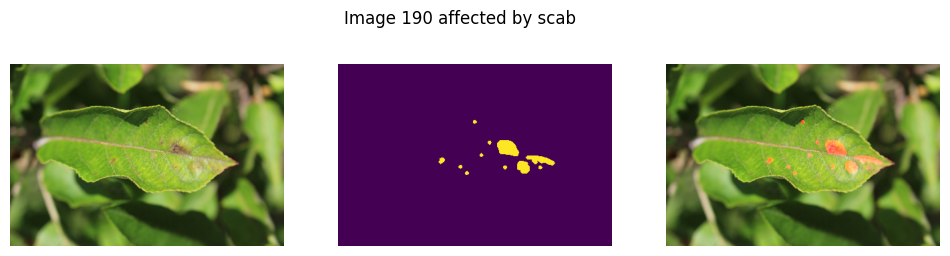

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..493].


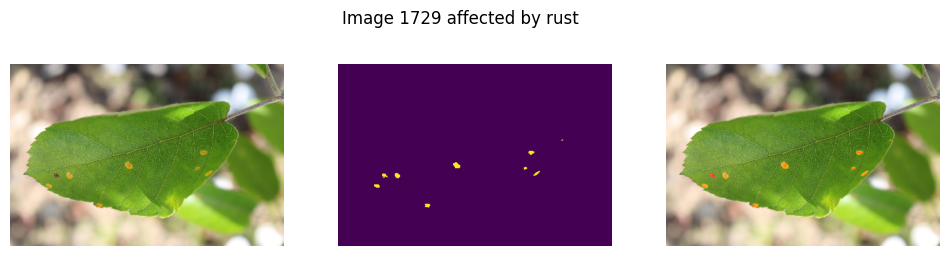

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [11..480].


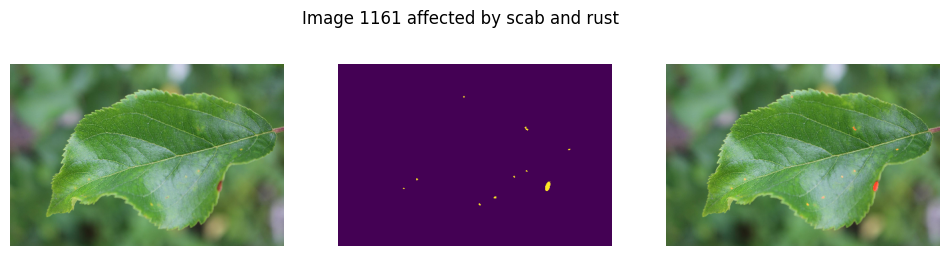

In [24]:
# example images from each type:

# Scab
plt.figure(figsize=(12,3))
idx = np.random.choice(scab_idxs)
img_path = make_path(type="scab", mask=False, idx=idx)
mask_path = make_path(type="scab", mask=True, idx=idx)
plt.subplot(1,3,1)
plt.imshow(open_and_scale(img_path))
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(transform_binary_mask(open_and_scale(mask_path)))
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(open_and_scale(img_path) + transform_mask(open_and_scale(mask_path)))
plt.axis("off")
plt.suptitle(f"Image {idx} affected by scab")
plt.show()

# Rust
plt.figure(figsize=(12,3))
idx = np.random.choice(rust_idxs)
img_path = make_path(type="rust", mask=False, idx=idx)
mask_path = make_path(type="rust", mask=True, idx=idx)
plt.subplot(1,3,1)
plt.imshow(open_and_scale(img_path))
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(transform_binary_mask(open_and_scale(mask_path)))
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(open_and_scale(img_path) + transform_mask(open_and_scale(mask_path)))
plt.axis("off")
plt.suptitle(f"Image {idx} affected by rust")
plt.show()

# Both
plt.figure(figsize=(12,3))
idx = np.random.choice(both_idxs)
img_path = make_path(type="both", mask=False, idx=idx)
mask_path = make_path(type="both", mask=True, idx=idx)
plt.subplot(1,3,1)
plt.imshow(open_and_scale(img_path))
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(transform_binary_mask(open_and_scale(mask_path)))
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(open_and_scale(img_path) + transform_mask(open_and_scale(mask_path)))
plt.axis("off")
plt.suptitle(f"Image {idx} affected by scab and rust")
plt.show()



(np.float64(-0.5), np.float64(169.5), np.float64(284.5), np.float64(-0.5))

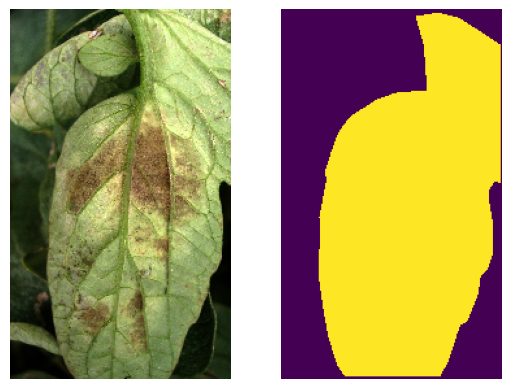

In [25]:
plt.subplot(1,2,1)
idx=np.random.randint(588)
im = open_and_scale(make_588_path(mask=False, idx=idx))
mask = (open_and_scale(make_588_path(mask=True, idx=idx)))

plt.imshow(im)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask)
plt.axis("off")


## Note - dataset agglomeration
Instead of using all the data, we select only the best data to use, out of the apple leaves dataset. 
To make sure we obtain an informative model, we only select images for which a mask containing information exists. 
Some images were incorrectly masked, and for this reason we need to select only the masks with information available.

We intend in the future to test the classification obtained with this data on the less organised pictures in the 588 leaf dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [9..475].


Image shape: (273, 410, 3)
Mask shape: (273, 410)


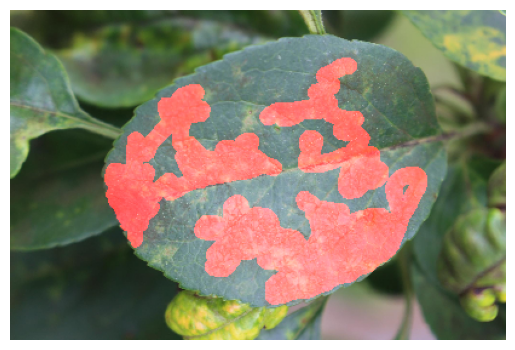

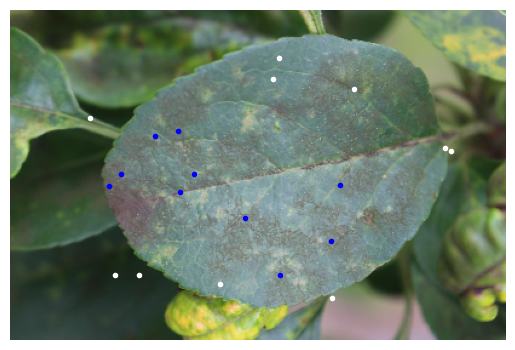

In [26]:
# extract 33 x 33 patches from disease patch
# multiple times
# 3 T, 3 F
# check icorsi code

# using professor's code

def pick_random_centers(mask, size=32, ignore=0):
    mask_ignored = mask.copy()
    mask_ignored[:ignore,:]=False
    mask_ignored[-ignore:,:]=False
    mask_ignored[:,:ignore]=False
    mask_ignored[:,-ignore:]=False
    rs, cs = np.where(mask_ignored)
    ix = np.random.randint(len(rs), size=size)
    return rs[ix], cs[ix]

patches = []
labels = []

idx = np.random.choice(scab_idxs)
img_path = make_path(type="scab", mask=False, idx=idx)
mask_path = make_path(type="scab", mask=True, idx=idx)

img = open_and_scale(img_path)
mask = transform_binary_mask(open_and_scale(mask_path))

print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

plt.imshow(img + transform_mask(open_and_scale(mask_path)))
plt.axis("off")
plt.show()

plt.imshow(img)
plt.axis("off")
rs,cs = pick_random_centers(mask, size=10, ignore=32)
plt.plot(cs, rs, 'b.')
for r,c in zip(rs,cs):
    patches.append(img[r-8:r+8, c-8:c+8, :])
    labels.append(mask[r,c])

rs,cs = pick_random_centers(~mask, size=10, ignore=32)
plt.plot(cs, rs, 'w.')
for r,c in zip(rs,cs):
    patches.append(img[r-8:r+8, c-8:c+8, :])
    labels.append(mask[r,c])


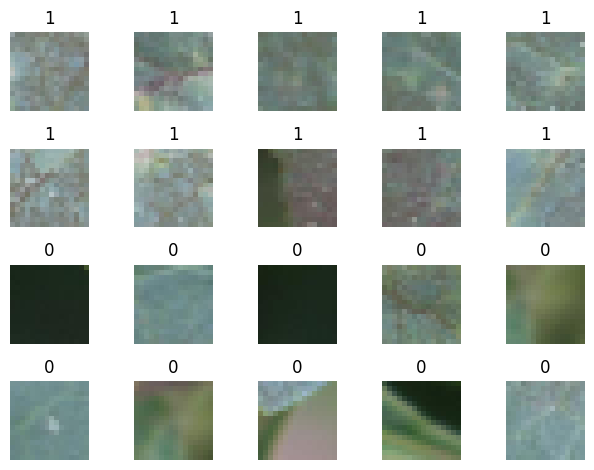

In [27]:
# display 33x33 areas around center pixel
for i in range(len(patches)):

    plt.subplot(4, 5, i+1)
    plt.title(labels[i] * 1)
    # plt.title("Disease patch" if labels[i] else "Leaf patch")
    plt.imshow(patches[i])
    plt.axis("off")


plt.tight_layout()
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [18..510].


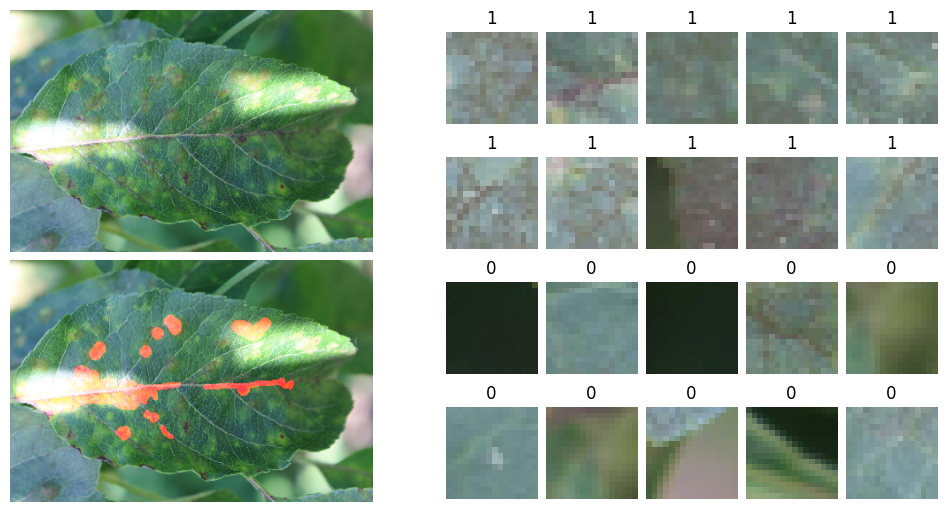

In [28]:
fig = plt.figure(layout="constrained", figsize=(10,5))

gs0 = fig.add_gridspec(1, 2)

gs1 = gs0[0].subgridspec(2, 1)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

# images_scab[50]
idx = np.random.choice(scab_idxs)
img_path = make_path(type="scab", mask=False, idx=idx)
mask_path = make_path(type="scab", mask=True, idx=idx)
ax1.imshow(open_and_scale(img_path))
ax1.axis("off")
ax2.imshow(open_and_scale(img_path) + transform_mask(open_and_scale(mask_path)))
ax2.axis("off")

gs2 = gs0[1].subgridspec(4, 5)
i = 0
for ss in gs2:
    ax = fig.add_subplot(ss)
    ax.imshow(patches[i])
    ax.set_title(labels[i] * 1)
    ax.axis("off")
    i += 1



In [29]:
def show_leaf_and_patches(img_path, 
                          mask_path, 
                          patch_radius=8,
                          n_patches=8):
    img = open_and_scale(img_path)
    mask = transform_mask(open_and_scale(mask_path))
    binary_mask = transform_binary_mask(open_and_scale(mask_path))

    fig = plt.figure(layout="constrained", figsize=(10,5))
    gs0 = fig.add_gridspec(1, 2)
    gs1 = gs0[0].subgridspec(2, 1)
    ax1 = fig.add_subplot(gs1[0])
    ax2 = fig.add_subplot(gs1[1])

    ax1.imshow(img + mask)
    ax1.set_title("Leaf with mask")
    ax1.axis("off")
    ax2.imshow(img)
    ax2.set_title("Selected patches")
    ax2.axis("off")

    patches = []
    labels = []

    rs,cs = pick_random_centers(binary_mask, size=n_patches, ignore=32)
    plt.plot(cs, rs, 'b.')
    for r,c in zip(rs,cs):
        patches.append(img[r-patch_radius:r+patch_radius, c-patch_radius:c+patch_radius, :])
        labels.append(binary_mask[r,c])

    rs,cs = pick_random_centers(~binary_mask, size=n_patches, ignore=32)
    ax2.plot(cs, rs, 'w.')
    for r,c in zip(rs,cs):
        patches.append(img[r-patch_radius:r+patch_radius, c-patch_radius:c+patch_radius, :])
        labels.append(binary_mask[r,c])

    gs2 = gs0[1].subgridspec(4, 4)
    i = 0
    for ss in gs2:
        ax = fig.add_subplot(ss)
        ax.imshow(patches[i])
        ax.set_title(labels[i] * 1)
        ax.axis("off")
        i += 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2..510].


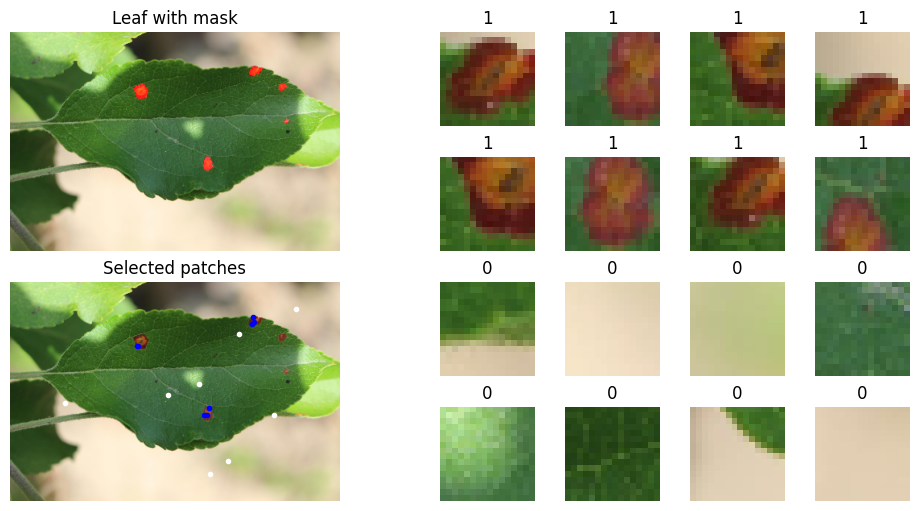

In [30]:
idx = np.random.choice(rust_idxs)
img_path = make_path(type="rust", mask=False, idx=idx)
mask_path = make_path(type="rust", mask=True, idx=idx)
show_leaf_and_patches(img_path, mask_path)



In [31]:
# create list of paths to use for display etc
scab_img_paths = [make_path(type="scab", mask=False, idx=i) for i in scab_idxs]
scab_mask_paths = [make_path(type="scab", mask=True, idx=i) for i in scab_idxs]

rust_img_paths = [make_path(type="rust", mask=False, idx=i) for i in rust_idxs]
rust_mask_paths = [make_path(type="rust", mask=True, idx=i) for i in rust_idxs]

both_img_paths = [make_path(type="both", mask=False, idx=i) for i in both_idxs]
both_mask_paths = [make_path(type="both", mask=True, idx=i) for i in both_idxs]

general_img_paths = [make_588_path(mask=False, idx=i) for i in idxs_588]
general_mask_paths = [make_588_path(mask=True, idx=i) for i in idxs_588]

all_img_paths = scab_img_paths + rust_img_paths + both_img_paths
all_mask_paths = scab_mask_paths + rust_mask_paths + both_mask_paths


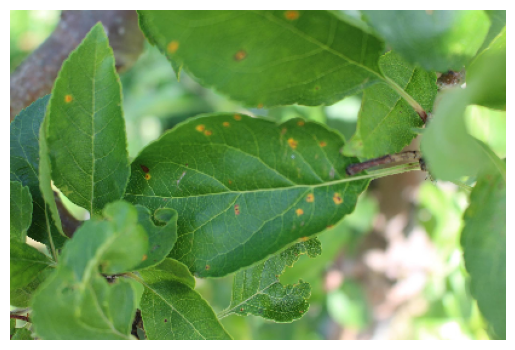

In [32]:
# test if the paths work
plt.imshow(open_and_scale(np.random.choice(all_img_paths)))
plt.axis("off")
plt.show()

## Splitting train and test sets

To handle edge cases we need to rewrite the patch extraction function to avoid errors when no valid pixels are found.

In [33]:
def pick_random_centers(mask, size=32, ignore=0):
    mask_ignored = mask.copy()
    mask_ignored[:ignore,:]=False
    mask_ignored[-ignore:,:]=False
    mask_ignored[:,:ignore]=False
    mask_ignored[:,-ignore:]=False
    rs, cs = np.where(mask_ignored)
    
    # this line was added to handle empty masks
    if len(rs) == 0:
        return np.array([], dtype=int), np.array([], dtype=int)
    
    # Limit size to available pixels
    size = min(size, len(rs))
    ix = np.random.randint(len(rs), size=size)
    return rs[ix], cs[ix]

In [34]:
import referencing


def create_dataset_from_images_and_masks(image_paths, mask_paths, patch_radius=8, n_patches=20, reference_size=250):
    patches = []
    labels = []

    for i in range(len(image_paths)):
        im = open_and_scale(image_paths[i], reference_size=reference_size)
        mask = transform_binary_mask(open_and_scale(mask_paths[i], reference_size=reference_size))
        rs, cs = pick_random_centers(mask, size=n_patches//2, ignore=32)
        if len(rs) == 0:
            continue

        for r, c in zip(rs, cs):
            patches.append(im[r-patch_radius:r+patch_radius, c-patch_radius:c+patch_radius, :])
            labels.append(mask[r, c])

        rs, cs = pick_random_centers(~mask, size=n_patches//2, ignore=32)
        
        if len(rs) == 0:
            continue
        for r, c in zip(rs, cs):
            patches.append(im[r-patch_radius:r+patch_radius, c-patch_radius:c+patch_radius, :])
            labels.append(mask[r, c])

    return np.array(patches), np.array(labels)


In [35]:

# n_images = 100
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_img_paths, all_mask_paths, test_size=0.2, random_state=42)


In [36]:
print(f"Total paths: {len(all_img_paths)}")
print(f"Paths in train set: {len(X_train)}")
print(f"Paths in test set: {len(X_test)}")
print(f"Sum: {len(X_train) + len(X_test)}")
print()

# test that the paths are in the training set
for i in range(2):
    print(X_train[i])
    print(y_train[i])

print()

for i in range(2):
    print(X_test[i])
    print(y_test[i])

Total paths: 873
Paths in train set: 698
Paths in test set: 175
Sum: 873

data_1291_leafs/img_rust/Train_1126.jpg
data_1291_leafs/masks_machine_rust/Train_1126.png
data_1291_leafs/img_rust/Train_108.jpg
data_1291_leafs/masks_machine_rust/Train_108.png

data_1291_leafs/img_both/Train_180.jpg
data_1291_leafs/masks_machine_both/Train_180.png
data_1291_leafs/img_scab/Train_1622.jpg
data_1291_leafs/masks_machine_scab/Train_1622.png


In [37]:
patches_train, labels_train = create_dataset_from_images_and_masks(X_train, y_train, n_patches=20)
patches_test, labels_test = create_dataset_from_images_and_masks(X_test, y_test, n_patches=20)


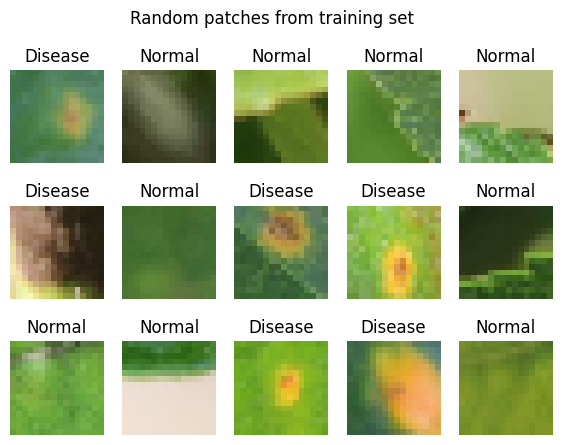

In [38]:
# show some of the training data
plt.figure(figsize=(7,5))
for i in range(15):
    plt.subplot(3,5,i+1)
    idx = np.random.randint(len(labels_train))
    plt.imshow(patches_train[idx])
    plt.title("Disease" if labels_train[idx] else "Normal")
    plt.axis("off")
plt.suptitle("Random patches from training set")
plt.show()


The patches represents well the disease and non-disease areas.

## Checking memory size of patches

In [39]:
def check_dataset_size(patches):
    size = 0
    for i in patches:
        size += i.nbytes
    return size / 1024 / 1024 # in MB

In [40]:
patches_train = patches_train.astype('float32') / 255.0
patches_test = patches_test.astype('float32') / 255.0
print("Training set size (MB):", check_dataset_size(patches_train))
print("Test set size (MB):", check_dataset_size(patches_test))
print("Training set size (number of patches):", patches_train.shape[0])
print("Test set size (number of patches):", patches_test.shape[0])


patches_train.shape, labels_train.shape, patches_test.shape, labels_test.shape

Training set size (MB): 40.8984375
Test set size (MB): 10.1865234375
Training set size (number of patches): 13960
Test set size (number of patches): 3477


((13960, 16, 16, 3), (13960,), (3477, 16, 16, 3), (3477,))

The training contains 13960 patches and weights around 40MB in memory, which is acceptable. In fact the model sees a lot of examples without using too much memory, which makes it better and more efficient.

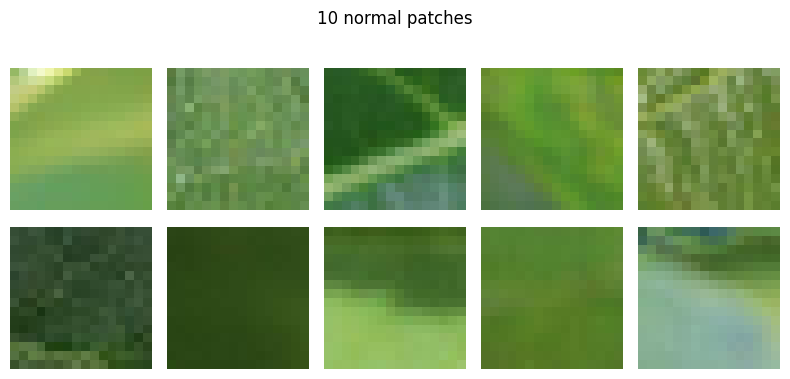

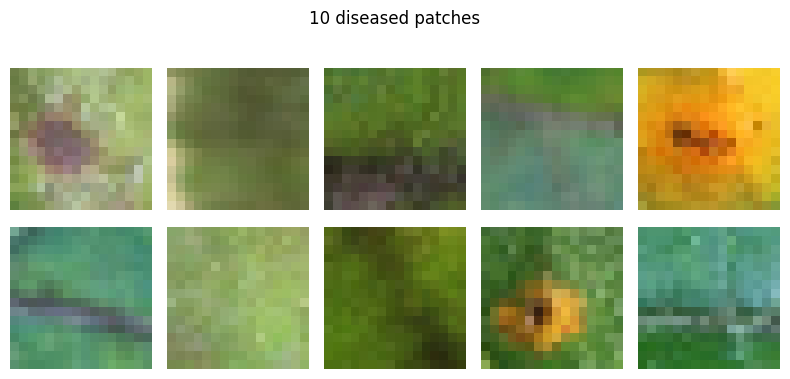

In [41]:
# visualise a set of patches

diseased_patches_train = patches_train[labels_train]
normal_patches_train = patches_train[~labels_train]

# visualise 10 normal patches

n_to_display = 10

plt.figure(figsize=(8,4))

for i in range(n_to_display):
    plt.subplot(2,5,i + 1)
    rnd_idx = np.random.randint(len(normal_patches_train))
    plt.imshow(normal_patches_train[rnd_idx])
    plt.axis("off")
    # plt.title("Diseased" if labels_train[rnd_idx] else "Normal")

plt.suptitle("10 normal patches")
plt.tight_layout()
plt.show()

# visualise 10 disease patches

n_to_display = 10

plt.figure(figsize=(8,4))

for i in range(n_to_display):
    plt.subplot(2,5,i + 1)
    rnd_idx = np.random.randint(len(diseased_patches_train))
    plt.imshow(diseased_patches_train[rnd_idx])
    plt.axis("off")
    # plt.title("Diseased" if labels_train[rnd_idx] else "Normal")

plt.suptitle("10 diseased patches")
plt.tight_layout()
plt.show()


# Training a simple model

As a benchmark, we train a simple CNN model on the patches extracted from the images. The models consists of a few convolutional layers followed by max-pooling layers, and finally dense layers for classification. We use ReLU activation functions.

/home/fjg/miniconda3/envs/fjgenv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1765122197.035249  494893 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13149 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/30


2025-12-07 16:43:18.351840: I external/local_xla/xla/service/service.cc:163] XLA service 0x72806400c220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-07 16:43:18.351851: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-12-07 16:43:18.371911: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-07 16:43:18.516094: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500
2025-12-07 16:43:18.538934: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-07 16:43:18.53898

152/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6212 - loss: 0.6170

I0000 00:00:1765122200.365795  496690 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6872 - loss: 0.5541  

2025-12-07 16:43:22.392285: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-07 16:43:22.864375: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 28 bytes spill stores, 28 bytes spill loads

2025-12-07 16:43:22.884025: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 24 bytes spill stores, 24 bytes spill loads



437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7388 - loss: 0.4995 - val_accuracy: 0.7599 - val_loss: 0.4699
Epoch 2/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8047 - loss: 0.4051 - val_accuracy: 0.8133 - val_loss: 0.3924
Epoch 3/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8428 - loss: 0.3521 - val_accuracy: 0.8355 - val_loss: 0.3645
Epoch 4/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8614 - loss: 0.3259 - val_accuracy: 0.8381 - val_loss: 0.3653
Epoch 5/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8691 - loss: 0.3091 - val_accuracy: 0.8565 - val_loss: 0.3292
Epoch 6/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8759 - loss: 0.2959 - val_accuracy: 0.8622 - val_loss: 0.3215
Epoch 7/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8786 - loss: 0.2861 - val_accuracy: 0.8706 - val_loss: 0.3066
Epoch 8/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8814 - loss: 0.2810 - val_accuracy: 0.8717 - val_

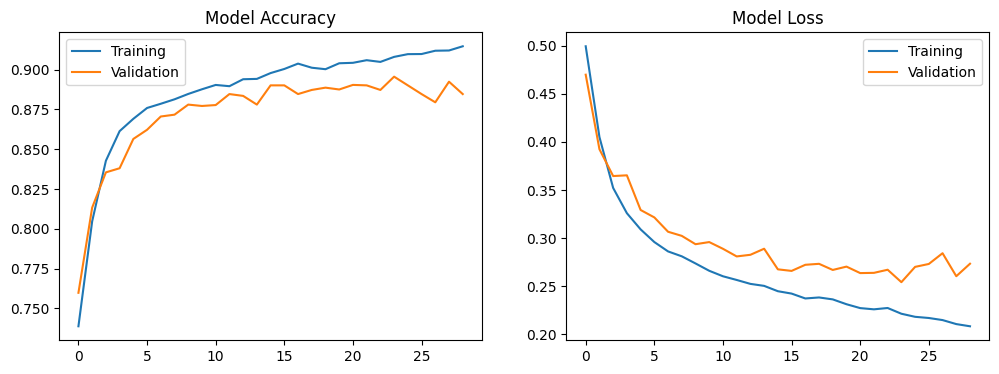

In [42]:

def train_simple_model(patches_train, labels_train, patches_test, labels_test):
    from keras.callbacks import EarlyStopping
    from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
    from keras.models import Sequential
    early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
    model = Sequential([
        Conv2D(16, (5, 5), activation='relu', input_shape=patches_train[0].shape),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid') # binary classification 
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(patches_train, labels_train,epochs=30,batch_size=32,validation_data=(patches_test, labels_test),callbacks=[early_stopping])
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.legend()
    plt.show()

    return model

simple_model = train_simple_model(patches_train, labels_train, patches_test, labels_test)

With just 14 epochs of training, the model achieves a training accuracy of around 90% and a validation accuracy of around 89%. This indicates that the model is able to learn useful features from the patches for distinguishing between diseased and healthy areas.

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


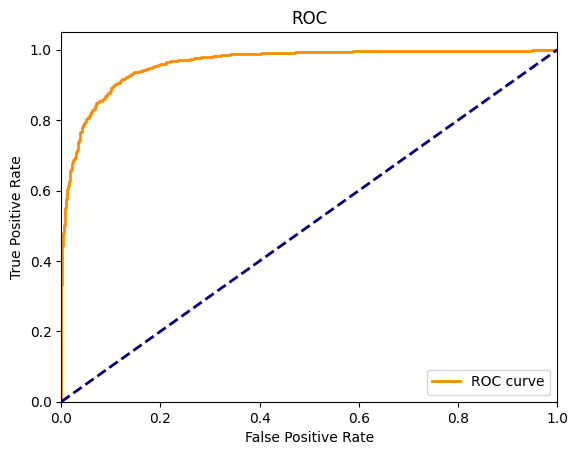

AUC: 0.9611858866191545
F1 Score: 0.8838883888388839
Accuracy: 0.8886971527178602
Average predicted probability for positive class: 0.84966207
Average predicted probability for negative class: 0.13080421


In [43]:

from importlib import simple
positive_class_threshold = 0.65

def evaluate_model_performance(model, patches_test, labels_test):
    from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score
    y_pred_prob = model.predict(patches_test).ravel()
    fpr, tpr, thresholds = roc_curve(labels_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()
    y_pred = (y_pred_prob > positive_class_threshold).astype(int)
    accuracy = accuracy_score(labels_test, y_pred)
    print("AUC:", roc_auc)
    print("F1 Score:", f1_score(labels_test, y_pred))
    print("Accuracy:", accuracy)
    print("Average predicted probability for positive class:", np.mean(y_pred_prob[labels_test == 1]))
    print("Average predicted probability for negative class:", np.mean(y_pred_prob[labels_test == 0]))

evaluate_model_performance(simple_model, patches_test, labels_test)

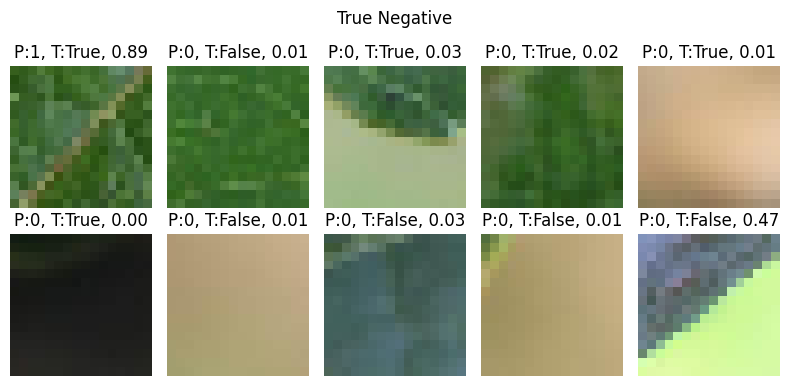

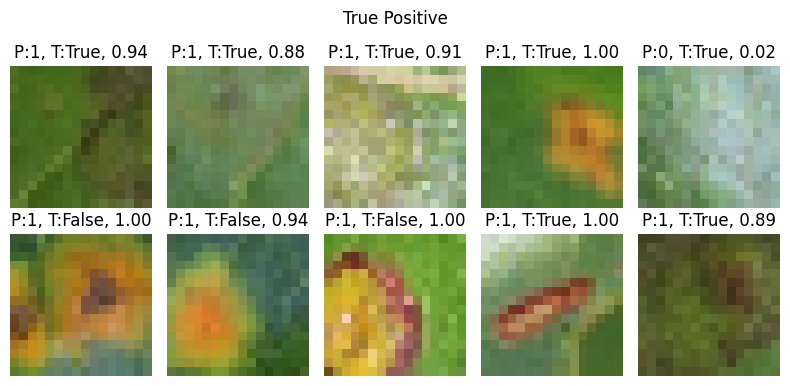

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step


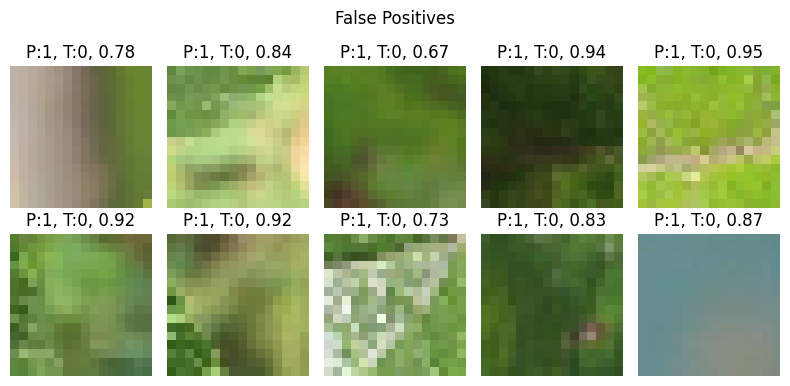

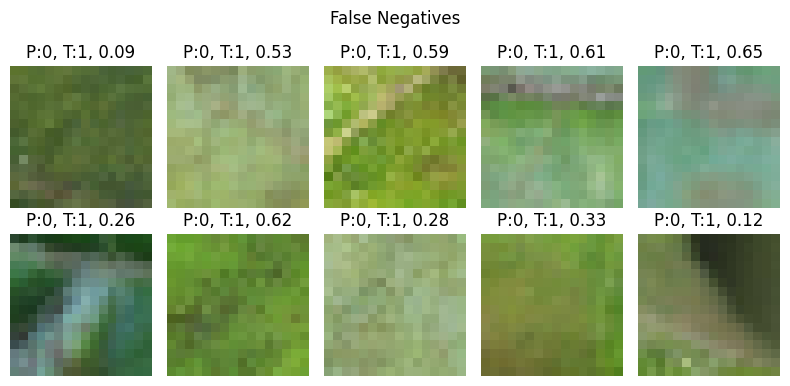

In [44]:

def visualize_sample_and_prediction(patches_test, labels_test, model):
    diseased_patches = patches_test[labels_test]
    normal_patches = patches_test[~labels_test]

    # Show normal patches
    plt.figure(figsize=(8, 4))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        idx = np.random.randint(len(normal_patches))
        patch = normal_patches[idx]
        pred_prob = model.predict(np.expand_dims(patch, axis=0), verbose=0).ravel()[0]
        pred_label = 1 if pred_prob > positive_class_threshold else 0
        plt.imshow(patch)
        plt.title(f"P:{pred_label}, T:{labels_test[idx]}, {pred_prob:.2f}")
        plt.axis("off")
    plt.suptitle("True Negative")
    plt.tight_layout()
    plt.show()

    # Show diseased patches
    plt.figure(figsize=(8, 4))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        idx = np.random.randint(len(diseased_patches))
        patch = diseased_patches[idx]
        pred_prob = model.predict(np.expand_dims(patch, axis=0), verbose=0).ravel()[0]
        pred_label = 1 if pred_prob > positive_class_threshold else 0
        plt.imshow(patch)
        plt.title(f"P:{pred_label}, T:{labels_test[idx]}, {pred_prob:.2f}")
        plt.axis("off")
    plt.suptitle("True Positive")
    plt.tight_layout()
    plt.show()

    #show 5 false positives
    y_pred_prob = model.predict(patches_test).ravel()
    y_pred = (y_pred_prob > positive_class_threshold).astype(int)
    false_positives_idxs = np.where((y_pred == 1) & (labels_test == 0))[0]
    plt.figure(figsize=(8, 4))
    for i in range(min(10, len(false_positives_idxs))):
        plt.subplot(2, 5, i + 1)
        idx = false_positives_idxs[np.random.randint(len(false_positives_idxs))]
        patch = patches_test[idx]
        pred_prob = y_pred_prob[idx]
        plt.imshow(patch)
        plt.title(f"P:1, T:0, {pred_prob:.2f}")
        plt.axis("off")
    plt.suptitle("False Positives")
    plt.tight_layout()
    plt.show()

    # show 5 false negatives
    false_negatives_idxs = np.where((y_pred == 0) & (labels_test == 1))[0]
    plt.figure(figsize=(8, 4))
    for i in range(min(10, len(false_negatives_idxs))):
        plt.subplot(2, 5, i + 1)
        idx = false_negatives_idxs[np.random.randint(len(false_negatives_idxs))]
        patch = patches_test[idx]
        pred_prob = y_pred_prob[idx]
        plt.imshow(patch)
        plt.title(f"P:0, T:1, {pred_prob:.2f}")
        plt.axis("off")
    plt.suptitle("False Negatives")
    plt.tight_layout()
    plt.show()


visualize_sample_and_prediction(patches_test, labels_test, simple_model)


# Training a complex model

Epoch 1/30


/home/fjg/miniconda3/envs/fjgenv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-07 16:43:43.932372: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-07 16:43:43.932398: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set in

437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7188 - loss: 0.5212

2025-12-07 16:43:50.535944: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-07 16:43:50.897567: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_98', 16 bytes spill stores, 16 bytes spill loads



437/437 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7852 - loss: 0.4412 - val_accuracy: 0.8289 - val_loss: 0.3897
Epoch 2/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8580 - loss: 0.3281 - val_accuracy: 0.8671 - val_loss: 0.3113
Epoch 3/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8637 - loss: 0.3111 - val_accuracy: 0.8703 - val_loss: 0.3173
Epoch 4/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8729 - loss: 0.2911 - val_accuracy: 0.8864 - val_loss: 0.2858
Epoch 5/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8866 - loss: 0.2735 - val_accuracy: 0.8824 - val_loss: 0.2809
Epoch 6/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8851 - loss: 0.2639 - val_accuracy: 0.8901 - val_loss: 0.2674
Epoch 7/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8933 - loss: 0.2557 - val_accuracy: 0.8956 - val_loss: 0.2705
Epoch 8/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8945 - loss: 0.2500 - val_accuracy: 0.8858 - val

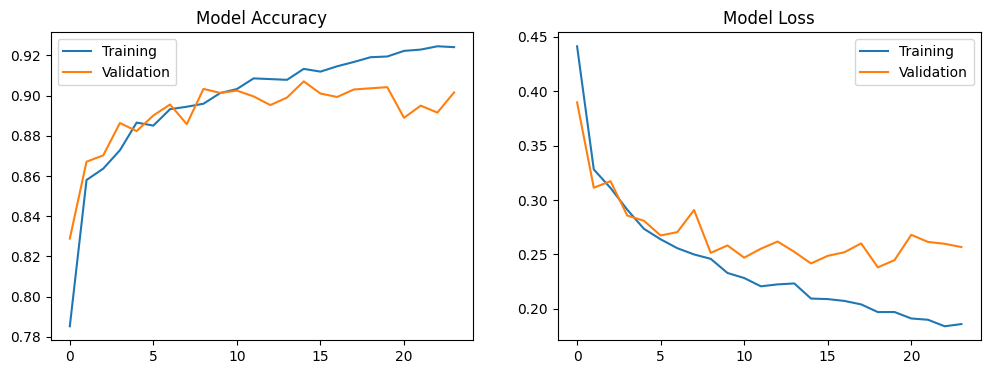

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


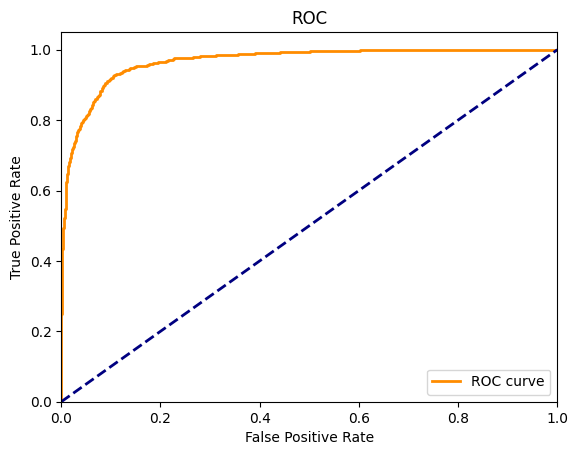

AUC: 0.9676863928427266
F1 Score: 0.9086206896551724
Accuracy: 0.908541846419327
Average predicted probability for positive class: 0.88935006
Average predicted probability for negative class: 0.15509412


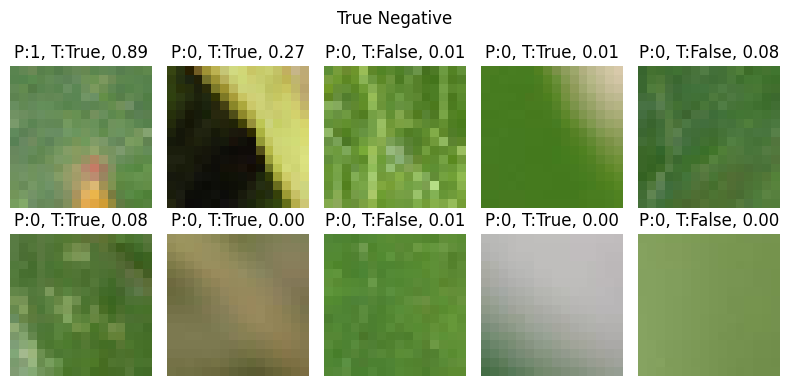

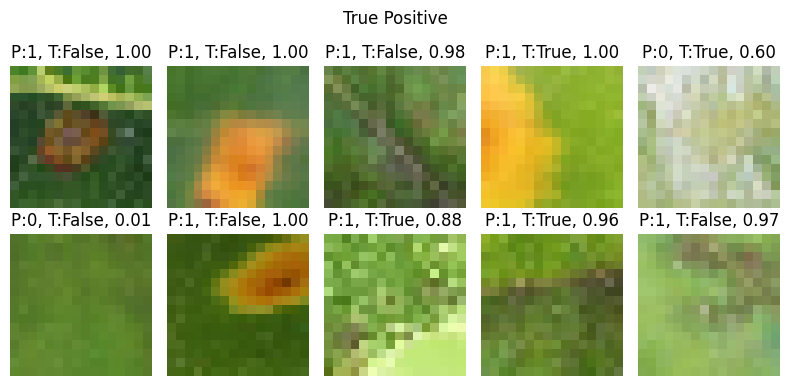

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


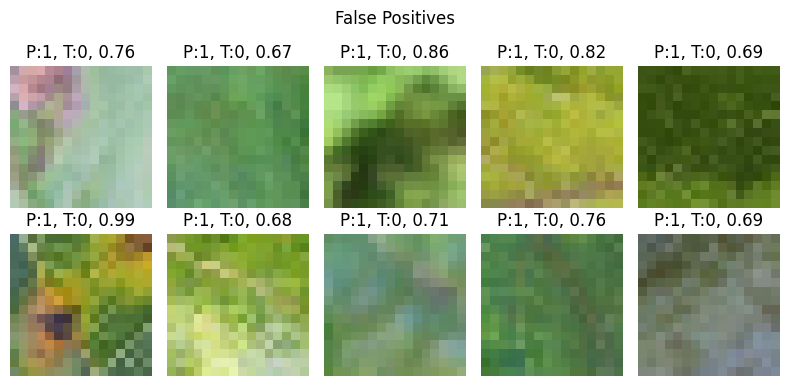

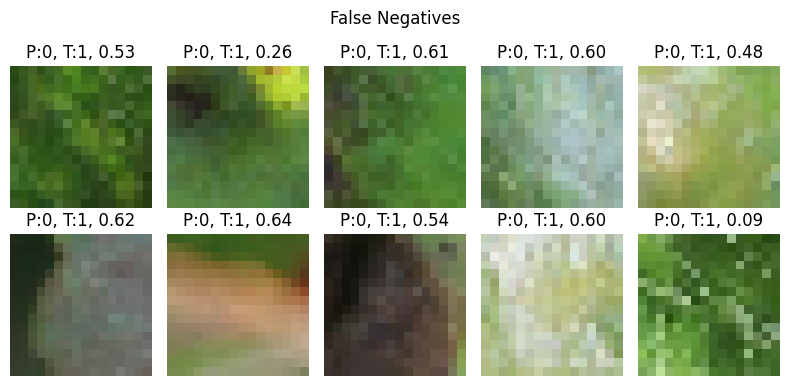

In [45]:
# the following is from professor's code
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

def train_complex_model(patches_train, labels_train, patches_test, labels_test):
    from keras.callbacks import EarlyStopping
    from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
    from keras.models import Sequential
    early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)


    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                    input_shape=patches_train[0].shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1)) # from the professor code this was 10, but we have binary classification hence 1
    model.add(Activation('sigmoid')) # there was a 

    model.compile(optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy'])

    history = model.fit(patches_train, labels_train, epochs=30, batch_size=32,
                        validation_data=(patches_test, labels_test), callbacks=[early_stopping])
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.legend()
    plt.show()

    return model

complex_model = train_complex_model(patches_train, labels_train, patches_test, labels_test)
evaluate_model_performance(complex_model, patches_test, labels_test)
visualize_sample_and_prediction(patches_test, labels_test, complex_model)       

# Fully Convolutional Neural Network (FCNN) for classification

Epoch 1/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7809 - loss: 0.4444 - val_accuracy: 0.7972 - val_loss: 0.4127
Epoch 2/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8495 - loss: 0.3367 - val_accuracy: 0.8484 - val_loss: 0.3330
Epoch 3/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8773 - loss: 0.2908 - val_accuracy: 0.8619 - val_loss: 0.3172
Epoch 4/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8884 - loss: 0.2682 - val_accuracy: 0.8746 - val_loss: 0.2830
Epoch 5/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8936 - loss: 0.2548 - val_accuracy: 0.8740 - val_loss: 0.2870
Epoch 6/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9002 - loss: 0.2416 - val_accuracy: 0.8939 - val_loss: 0.2564
Epoch 7/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9062 - loss: 0.2284 - val_accuracy: 0.8789 - val_loss: 0.2859
Epoch 8/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9125 - loss: 0.2156 - val_accuracy: 0.

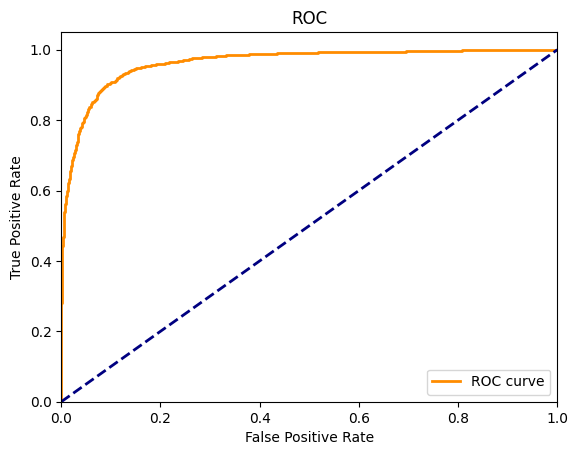

AUC: 0.9638516665674071
F1 Score: 0.9016632623285673
Accuracy: 0.9030773655450101
Average predicted probability for positive class: 0.89335316
Average predicted probability for negative class: 0.16261992


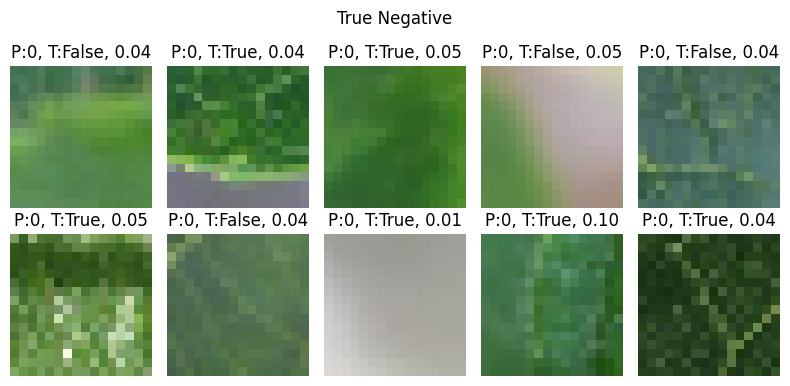

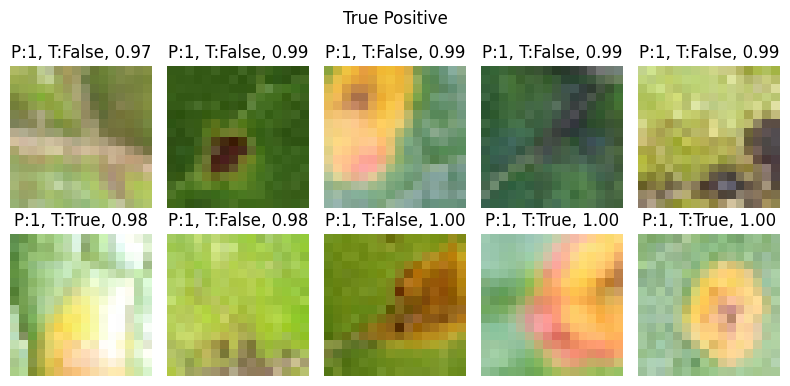

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


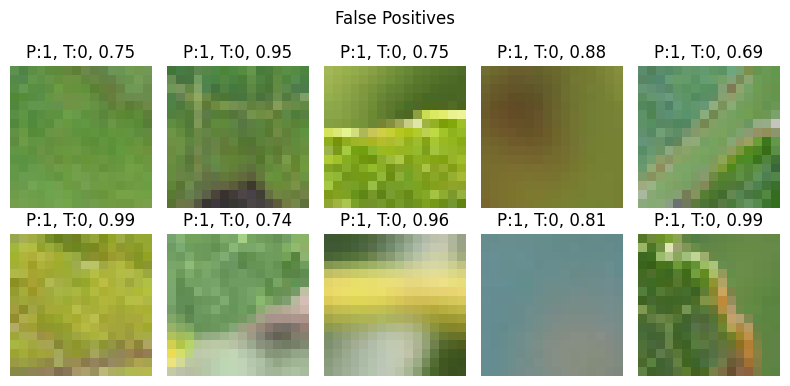

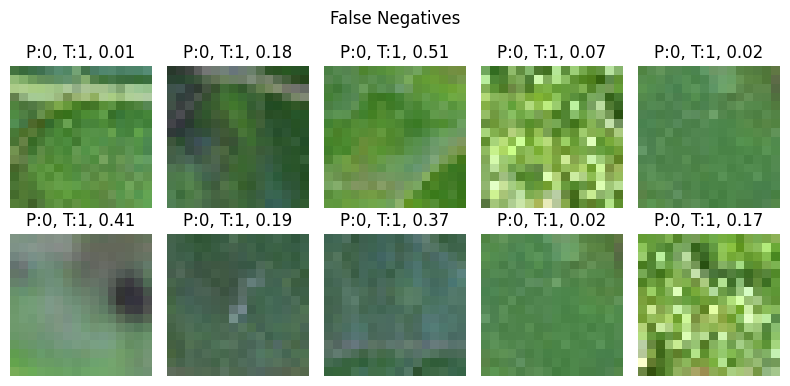

In [46]:
import keras
import keras.layers

def train_fully_connected_NN(patches_train, labels_train, patches_test, labels_test):
    input_layer = keras.Input(shape=patches_train.shape[1:], name='input')
    x = keras.layers.Conv2D(filters=4, kernel_size=(3,3), padding='same', activation='relu')(input_layer)
    x = keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same', activation='relu')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=input_layer, outputs=x)
    model.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(patches_train, labels_train, validation_data=(patches_test, labels_test), epochs=10, batch_size=32)

    return model

fc_model = train_fully_connected_NN(patches_train, labels_train, patches_test, labels_test)
evaluate_model_performance(fc_model, patches_test, labels_test)
visualize_sample_and_prediction(patches_test, labels_test, fc_model)


# Evaluating on the hold-out test set to assess generalization performance



The specific disease dataset is larger, cleaner, and has more consistent masks, which helps the model learn better features for classification. On the other hand, the diverse dataset has more variability in terms of image quality, lighting conditions, and types of leaves and diseases represented. This variability can make it harder for the model to generalize well, especially if the training data does not cover all the variations present in the test set. We'll use the diverse dataset as an additional test set to see how well the model trained on the specific disease dataset generalizes to new, unseen data.

In [47]:
hold_out_test_patches, hold_out_test_labels = create_dataset_from_images_and_masks(general_img_paths, general_mask_paths, n_patches=20, reference_size=0)
hold_out_test_labels.shape


(11750,)

368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


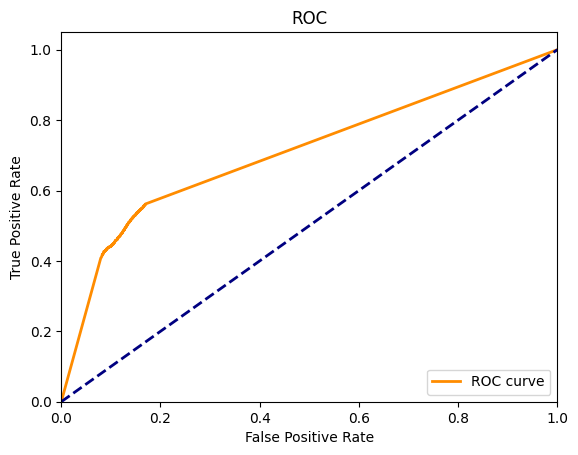

AUC: 0.7084228870423808
F1 Score: 0.5675675675675675
Accuracy: 0.670468085106383
Average predicted probability for positive class: 0.43331888
Average predicted probability for negative class: 0.09148878


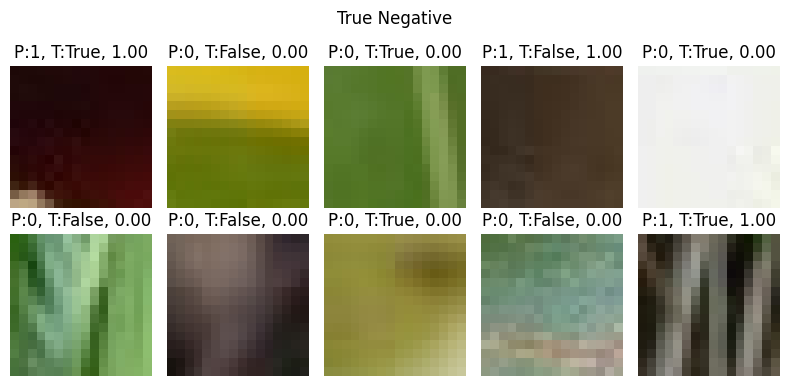

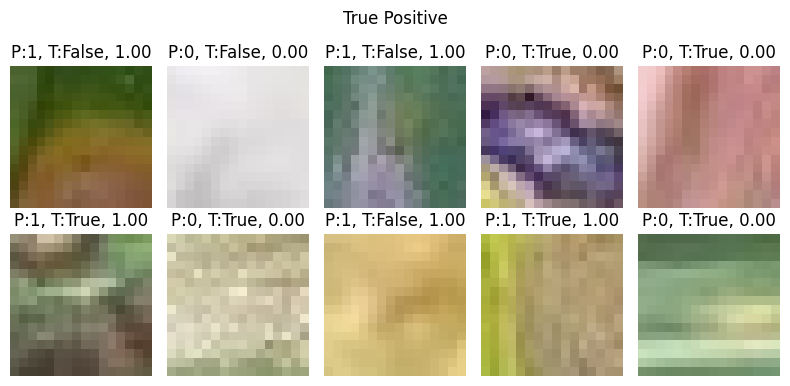

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


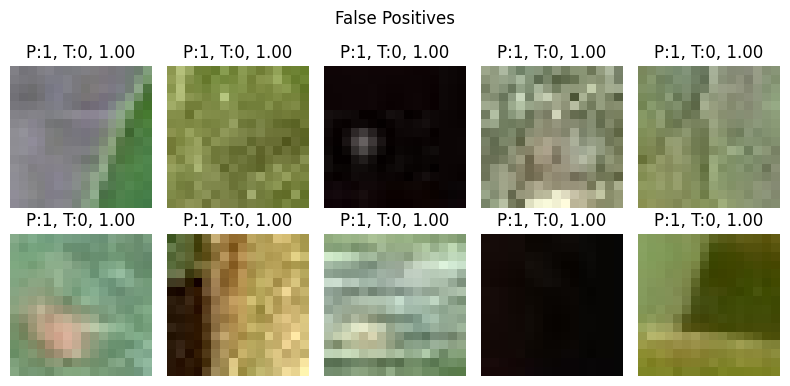

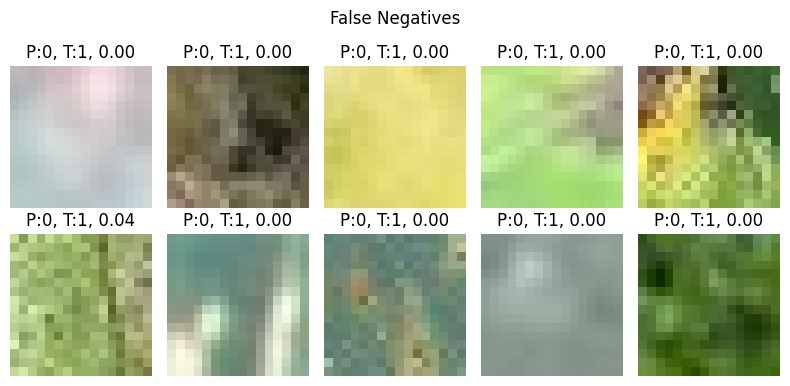

In [48]:
evaluate_model_performance(simple_model, hold_out_test_patches, hold_out_test_labels)
visualize_sample_and_prediction(hold_out_test_patches, hold_out_test_labels, simple_model)

368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


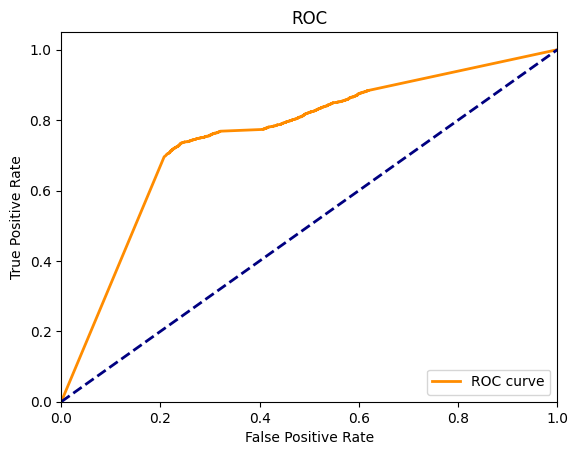

AUC: 0.7568746016294081
F1 Score: 0.741005358509824
Accuracy: 0.7408510638297873
Average predicted probability for positive class: 0.74363106
Average predicted probability for negative class: 0.26575297


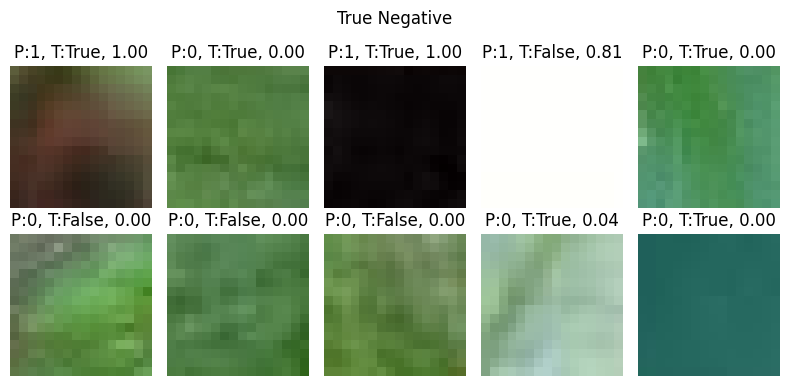

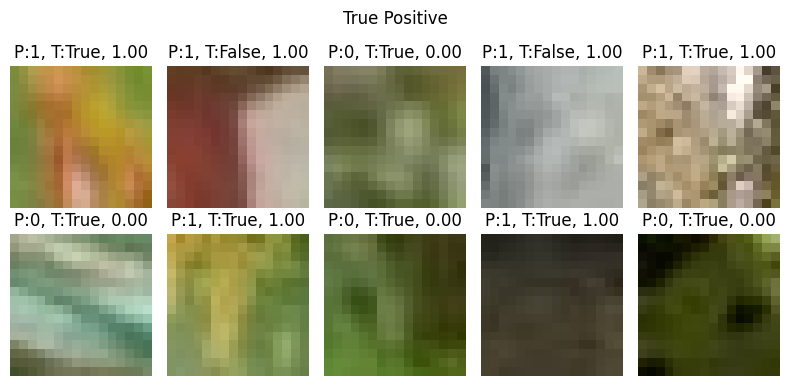

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


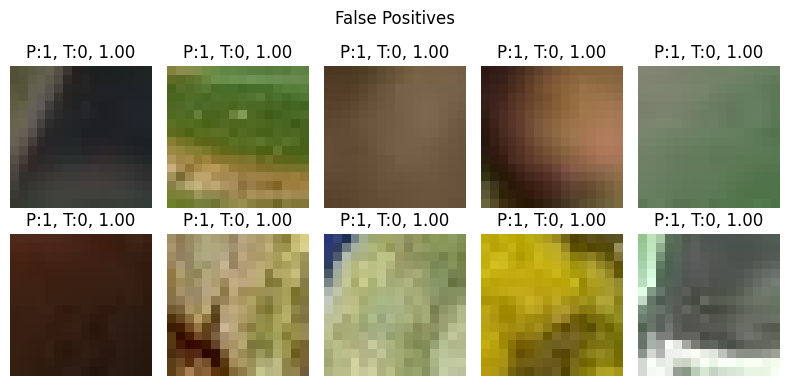

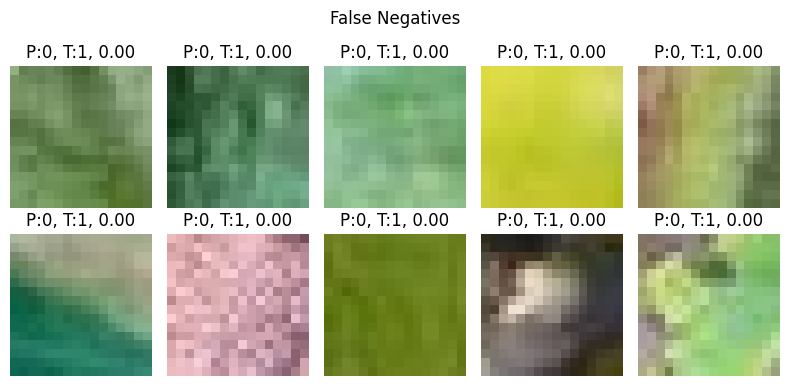

In [49]:
evaluate_model_performance(complex_model, hold_out_test_patches, hold_out_test_labels)
visualize_sample_and_prediction(hold_out_test_patches, hold_out_test_labels, complex_model)

368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


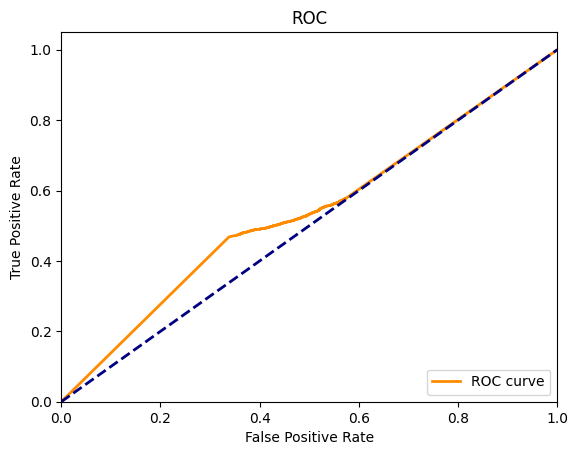

AUC: 0.5369266070993985
F1 Score: 0.5200146225552915
Accuracy: 0.5530212765957446
Average predicted probability for positive class: 0.48429832
Average predicted probability for negative class: 0.37909046


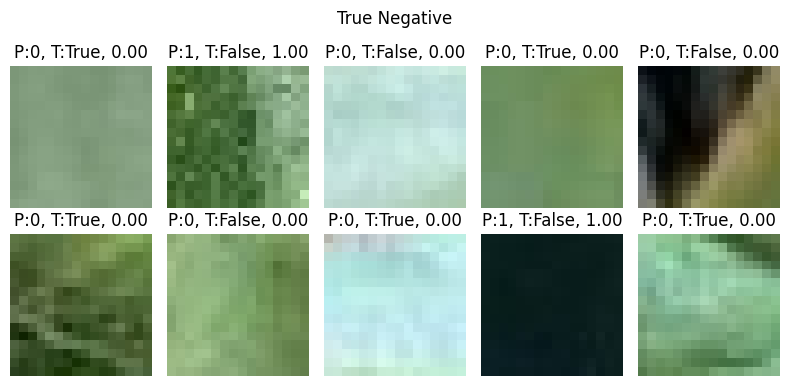

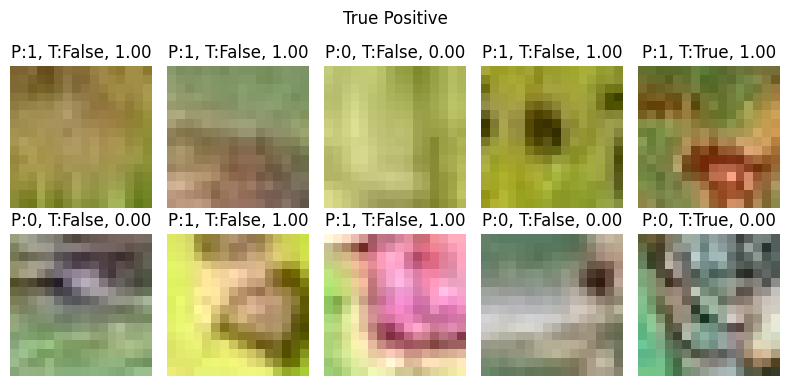

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step


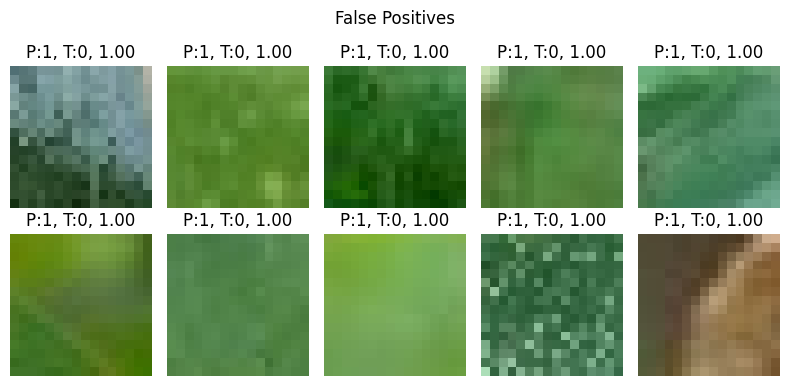

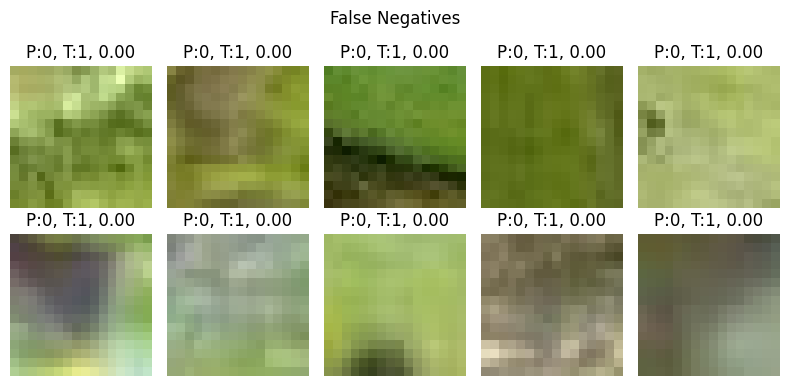

In [50]:
evaluate_model_performance(fc_model, hold_out_test_patches, hold_out_test_labels)
visualize_sample_and_prediction(hold_out_test_patches, hold_out_test_labels, fc_model)

# Final comparison of models

In [51]:
def compare_all_models_with_barcharts(simple_model, complex_model, fc_model, patches_test, labels_test):
    import numpy as np
    from sklearn.metrics import accuracy_score, f1_score
    import matplotlib.pyplot as plt

    models = [simple_model, complex_model, fc_model]
    names = ["Simple CNN", "Complex CNN", "Fully Convolutional NN"]

    accuracies = []
    f1_scores = []

    for model in models:
        y_pred = (model.predict(patches_test).ravel() > positive_class_threshold).astype(int)
        accuracies.append(accuracy_score(labels_test, y_pred))
        f1_scores.append(f1_score(labels_test, y_pred))

    x = np.arange(len(models))
    width = 0.3
    fig, ax = plt.subplots(figsize=(8, 5))
    bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
    bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

    ax.set_ylabel('Score')
    ax.set_title('Model Performance')
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylim(0, 1)
    ax.legend()

    # Add values on top of bars
    for bar in list(bars1) + list(bars2):
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.show()

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


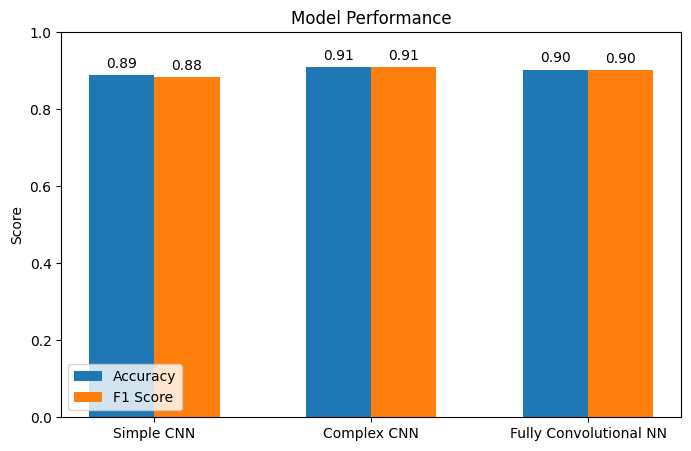

In [52]:
compare_all_models_with_barcharts(simple_model, complex_model, fc_model, patches_test, labels_test)


368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


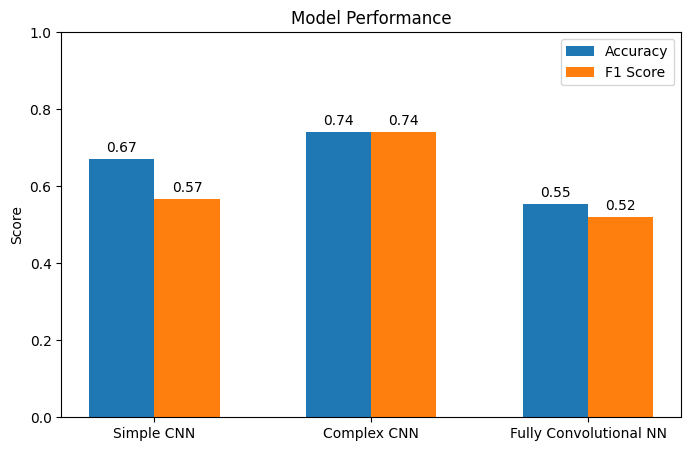

In [53]:
compare_all_models_with_barcharts(simple_model, complex_model, fc_model, hold_out_test_patches, hold_out_test_labels)